In [2]:
import torch
import ot
import geoopt
# import scipy.linalg
import sys

import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.distributions as D

from tqdm.auto import trange
from geoopt import linalg
from pyriemann.datasets import sample_gaussian_spd, generate_random_spd_matrix

sys.path.append("./lib")
from swspd import *
from utils_spd import busemann_spd

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

## Sliced-Wasserstein

#### Wishart Distribution

In [4]:
m0 = D.Wishart(torch.tensor([2], dtype=torch.float64).to(device), torch.eye(2, dtype=torch.float64, device=device))

manifold_ai = geoopt.SymmetricPositiveDefinite("AIM")
manifold_le = geoopt.SymmetricPositiveDefinite("LEM")

ntry = 20
nsamples = 500
nprojs = 500

a = torch.ones((nsamples,), device=device, dtype=torch.float64)/nsamples
b = torch.ones((nsamples,), device=device, dtype=torch.float64)/nsamples

ts = torch.linspace(0.1,10,100)
L_sw_wishart = np.zeros((ntry, len(ts)))
L_w_ai_wishart = np.zeros((ntry, len(ts)))
L_w_le_wishart = np.zeros((ntry, len(ts)))

bar = trange(ntry)
for k in bar:
    # pbar = trange(len(ts))
    pbar = range(len(ts))
    for i in pbar:
        t = ts[i]
        mt = D.Wishart(torch.tensor([2], dtype=torch.float64).to(device), t*torch.eye(2, dtype=torch.float64, device=device))
        B0 = m0.sample((nsamples,))[:,0]
        Bt = mt.sample((nsamples,))[:,0]

        sw = sliced_wasserstein_spd(B0, Bt, nprojs, device=device).item()
        L_sw_wishart[k, i] = sw


        M = manifold_ai.dist(B0[:,None], Bt[None])**2

        w = ot.emd2(a, b, M)
        L_w_ai_wishart[k, i] = w.item()


        M = manifold_le.dist(B0[:,None], Bt[None])**2

        w = ot.emd2(a, b, M)
        L_w_le_wishart[k, i] = w.item()

/usr/local/lib/python3.8/dist-packages/geoopt/manifolds/symmetric_positive_definite.py:52: UserWarning: SPDMetric.LEM is not fully implemented and results may be not as you expect
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/torch/distributions/wishart.py:247: UserWarning: Singular sample detected.
  warnings.warn("Singular sample detected.")


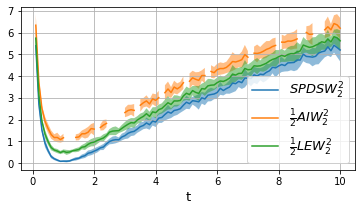

In [5]:
m = np.mean(L_sw_wishart, axis=0)
s = np.std(L_sw_wishart, axis=0)

plt.figure(figsize=(6,3))
plt.plot(ts, m, label=r"$SPDSW_2^2$")
plt.fill_between(ts, m-s, m+s, alpha=0.5)


m = np.mean(L_w_ai_wishart/2, axis=0)
s = np.std(L_w_ai_wishart/2, axis=0)

plt.plot(ts, m, label=r"$\frac{1}{2} AIW_2^2$")
plt.fill_between(ts, m-s, m+s, alpha=0.5)

m = np.mean(L_w_le_wishart/2, axis=0)
s = np.std(L_w_le_wishart/2, axis=0)

plt.plot(ts, m, label=r"$\frac{1}{2} LEW_2^2$")
plt.fill_between(ts, m-s, m+s, alpha=0.5)

plt.xlabel("t", fontsize=13)
plt.legend(fontsize=13)
plt.grid(True)
plt.savefig("./SW_vs_W_Wishart.pdf", format="pdf", bbox_inches="tight")
plt.show()

#### Test Gaussian Distributions

In [7]:
theta = np.random.normal(size=(1, 2))
theta = F.normalize(torch.from_numpy(theta), p=2, dim=-1).to(device)

A = theta[:,None] * torch.eye(theta.shape[-1], device=device)

In [10]:
manifold_ai = geoopt.SymmetricPositiveDefinite("AIM")
manifold_le = geoopt.SymmetricPositiveDefinite("LEM")

ntry = 10
nsamples = 500
nprojs = 500

ts = torch.linspace(-10,10,100)
L_sw_gaussians = np.zeros((ntry, len(ts)))
L_w_ai_gaussians = np.zeros((ntry, len(ts)))
L_w_le_gaussians = np.zeros((ntry, len(ts)))


mean0 = np.eye(2)
sigma0 = 1
sigma1 = 1

bar = trange(ntry)
for k in bar:
    pbar = range(len(ts))

    for i in pbar:
        t = ts[i]
        
        mean1 = torch.linalg.matrix_exp(t*A[0]).cpu().numpy()

        ## Slow as not implemented on pytorch
        B0 = torch.tensor(sample_gaussian_spd(n_matrices=nsamples, mean=mean0, sigma=sigma0), device=device)
        Bt = torch.tensor(sample_gaussian_spd(n_matrices=nsamples, mean=mean1, sigma=sigma1), device=device)
        
        sw = sliced_wasserstein_spd(B0, Bt, nprojs, device=device).item()
        L_sw_gaussians[k, i] = sw


        a = torch.ones((nsamples,), device=device, dtype=torch.float64)/nsamples
        b = torch.ones((nsamples,), device=device, dtype=torch.float64)/nsamples

        M = manifold_ai.dist(B0[:,None], Bt[None])**2
        w = ot.emd2(a, b, M)
        L_w_ai_gaussians[k, i] = w.item()


        M = manifold_le.dist(B0[:,None], Bt[None])**2
        w = ot.emd2(a, b, M)
        L_w_le_gaussians[k, i] = w.item()

    

/usr/local/lib/python3.8/dist-packages/geoopt/manifolds/symmetric_positive_definite.py:52: UserWarning: SPDMetric.LEM is not fully implemented and results may be not as you expect
  warnings.warn(


  0%|          | 0/10 [00:00<?, ?it/s]

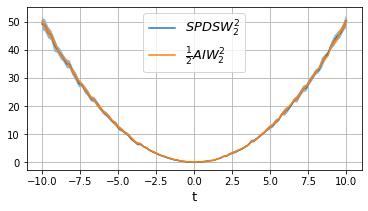

In [15]:
m = np.mean(L_sw_gaussians, axis=0)
s = np.std(L_sw_gaussians, axis=0)

plt.figure(figsize=(6,3))
plt.plot(ts, m, label=r"$SPDSW_2^2$")
plt.fill_between(ts, m-s, m+s, alpha=0.5)


m = np.mean(L_w_ai_gaussians/2, axis=0)
s = np.std(L_w_ai_gaussians/2, axis=0)

plt.plot(ts, m, label=r"$\frac{1}{2} AIW_2^2$")
plt.fill_between(ts, m-s, m+s, alpha=0.5)

# m = np.mean(L_w_le_gaussians/2, axis=0)
# s = np.std(L_w_le_gaussians/2, axis=0)

# plt.plot(ts, m, label=r"$\frac{1}{2} LEW_2^2$")
# plt.fill_between(ts, m-s, m+s, alpha=0.5)

plt.xlabel("t", fontsize=13)
plt.legend(fontsize=13)
plt.grid(True)
plt.savefig("./SW_vs_W_Gaussians.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [18]:
B = torch.rand(2,2)
A = (B+B.T)/2 

In [20]:
manifold_ai = geoopt.SymmetricPositiveDefinite("AIM")
manifold_le = geoopt.SymmetricPositiveDefinite("LEM")

ntry = 10
nsamples = 250
nprojs = 500

ts = torch.linspace(-10,10,100)
L_sw_gaussians = np.zeros((ntry, len(ts)))
L_w_ai_gaussians = np.zeros((ntry, len(ts)))
L_w_le_gaussians = np.zeros((ntry, len(ts)))


mean0 = np.eye(2)
sigma0 = 1
sigma1 = 1

bar = trange(ntry)
for k in bar:
    pbar = range(len(ts))

    for i in pbar:
        t = ts[i]
        
        mean1 = torch.linalg.matrix_exp(t*A).cpu().numpy()

        ## Slow as not implemented on pytorch
        B0 = torch.tensor(sample_gaussian_spd(n_matrices=nsamples, mean=mean0, sigma=sigma0), device=device)
        Bt = torch.tensor(sample_gaussian_spd(n_matrices=nsamples, mean=mean1, sigma=sigma1), device=device)
        
        sw = sliced_wasserstein_spd(B0, Bt, nprojs, device=device).item()
        L_sw_gaussians[k, i] = sw


        a = torch.ones((nsamples,), device=device, dtype=torch.float64)/nsamples
        b = torch.ones((nsamples,), device=device, dtype=torch.float64)/nsamples

        M = manifold_ai.dist(B0[:,None], Bt[None])**2
        w = ot.emd2(a, b, M)
        L_w_ai_gaussians[k, i] = w.item()


        M = manifold_le.dist(B0[:,None], Bt[None])**2
        w = ot.emd2(a, b, M)
        L_w_le_gaussians[k, i] = w.item()

    

/usr/local/lib/python3.8/dist-packages/geoopt/manifolds/symmetric_positive_definite.py:52: UserWarning: SPDMetric.LEM is not fully implemented and results may be not as you expect
  warnings.warn(


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/pyriemann/datasets/sampling.py:363: UserWarning: Some of the sampled matrices are very badly conditioned and                may not behave numerically as a SPD matrix. Try sampling again                or reducing the dimensionality of the matrix.
  warnings.warn(msg)
<ipython-input-20-3b9e69159f0b>:25: UserWarning: An output with one or more elements was resized since it had shape [1, 2, 2], which does not match the required output shape [1, 1, 2, 2]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  ../aten/src/ATen/native/Resize.cpp:17.)
  mean1 = torch.linalg.matrix_exp(t*A).cpu().numpy()


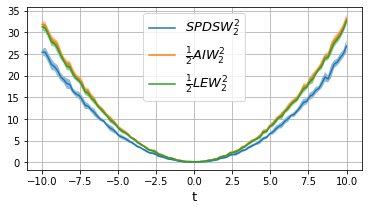

In [21]:
m = np.mean(L_sw_gaussians, axis=0)
s = np.std(L_sw_gaussians, axis=0)

plt.figure(figsize=(6,3))
plt.plot(ts, m, label=r"$SPDSW_2^2$")
plt.fill_between(ts, m-s, m+s, alpha=0.5)


m = np.mean(L_w_ai_gaussians/2, axis=0)
s = np.std(L_w_ai_gaussians/2, axis=0)

plt.plot(ts, m, label=r"$\frac{1}{2} AIW_2^2$")
plt.fill_between(ts, m-s, m+s, alpha=0.5)

m = np.mean(L_w_le_gaussians/2, axis=0)
s = np.std(L_w_le_gaussians/2, axis=0)

plt.plot(ts, m, label=r"$\frac{1}{2} LEW_2^2$")
plt.fill_between(ts, m-s, m+s, alpha=0.5)

plt.xlabel("t", fontsize=13)
plt.legend(fontsize=13)
plt.grid(True)
plt.savefig("./SW_vs_W_Gaussians_DONTCOMMUTE.pdf", format="pdf", bbox_inches="tight")
plt.show()